# Calculate KS Statistic on Real and Gaussian Data
In this notebook, it is possible to perform a KS statistic test between gaussian noise and real data power spectrums. It is also possible to compare between using Pspec and calculating manually the power spectrum.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gspec
from scipy.optimize import curve_fit
import math
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
def Simulated_Gaussian_Noise(sigma,mu):
    
    for time in range(0,60):
        if time == 0:
            visibility_data = np.random.normal(mu,sigma,1024)
        else:
            noise = np.random.normal(mu,sigma,1024)
        if time != 0:
            visibility_data = np.vstack((visibility_data,noise))
    
    return visibility_data

In [22]:
def Pspec_Data(baseline,fmin,n_dly,data_quantity,pol):
    
    # Set up the key for the power spectrum data
    key=(0,(baseline,baseline),pol)

    power_set = []
    spw_range = []
    delay_index_range = []
    null_power_set = []
    #num_delays = np.min(data_quantity)
    # The -2 is there to avoid generating power spectrums where the spw range is too small.
    for num in data_quantity:
        
        uvp = ds.pspec([baseline], [baseline], (0, 1), [(pol, pol)],spw_ranges=[(fmin,fmin+num)],exact_norm=False,n_dlys = None,norm = 'I',input_data_weight='identity', taper='blackman-harris', verbose=False)
        # We calculate the size of the spectral window depending on the number of iterations
        n_dly=num
        power = np.abs(np.real(uvp.get_data(key)))
        power_set.append(power)
        spw_range.append('('+str(int(uvd.freq_array[0,fmin]/1e4)/100)+'-'+str(int(uvd.freq_array[0,fmin+num]/1e4)/100)+')')
        delay_index_range.append([int(2*(n_dly)/3),n_dly])
        
        odd_time_power = power[::2,:]
        even_time_power = power[1::2,:]
        null_power_set.append(np.subtract(odd_time_power,even_time_power))
    # We return the data as a list containings lists.
    return power_set,delay_index_range,spw_range,null_power_set

In [14]:
def Direct_Data(fmin,vis_data,data_quantity):
    spw_range = []
    power_set = []
    delay_index_range = []
    null_power_set = []
    for num in data_quantity:
        #delay_data = np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis_data[],axes=1),axis=1),axes=1)
        k = np.trapz(uvb.power_beam_sq_int('XX')/(uvb.power_beam_int('XX')**2),uvb.beam_freqs)/((num*(uvb.beam_freqs[1]-uvb.beam_freqs[0]))**2)
        delay_data = np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis_data[:,fmin:fmin+num],axes=1),axis=1),axes=1)
        odd_v = delay_data[::2,:]
        even_v = delay_data[1::2,:]
        n_dly=num
        if odd_v.shape[0] != even_v.shape[0]:
            print(odd_v.shape[0],even_v.shape[0])
            if odd_v.shape[0] > even_v.shape[0]:
                odd_v = odd_v[0:-1,:]
            else:
                even_v = even_v[0:-1,:]
        power = np.abs(even_v)*np.abs(odd_v)/(k*num**2)
        odd_time_power = power[::2,:]
        even_time_power = power[1::2,:]
        null_power_set.append(np.subtract(odd_time_power,even_time_power))
        #power.append(np.abs(even_v[:,fmin:fmin+num])*np.abs(odd_v[:,fmin:fmin+num])/(k*num**2))
        spw_range.append('('+str(int(uvd.freq_array[0,fmin]/1e4)/100)+'-'+str(int(uvd.freq_array[0,fmin+num]/1e4)/100)+')')
        power_set.append(power)
        delay_index_range.append([int(2*(n_dly)/3),n_dly])
    return power,delay_index_range,spw_range,null_power_set

In [5]:
def ks_test(data, pdf, guess_args):
    """
    H0: the data follow a given distribution
    d < critical value (cv)  -->> accept H0
    
    Parameters
    ----------
    data: 1d array
        empirical data 
    pdf: callable
        probability density function
    guess_args: float, 1d array
        pdf parameters guess
        
    Returns
    -------
    d: float
        KS-test stats
    cv: float
        critical value (Significance level:  α = 0.05)
    m: Boolean
        KS-test result: Accept H0 (True); reject H0 (False)
    """
    
    # get CDF of empirical data
    counts, bin_edges = np.histogram (data, bins=len(data), density=True)
    ecdf = np.cumsum(counts)/(np.cumsum(counts)[-1])
    
    # fit data to the model 
    y, x = np.histogram(data, bins='auto', density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    popt, pcov = curve_fit(pdf, x, y, p0=guess_args)
    
    # compute CDF from the fitted PDF
    cdf_scaled = np.cumsum(pdf(bin_edges[1:], *popt))
    cdf = cdf_scaled/cdf_scaled[-1]
    
    # perform KS-test
    gaps = np.column_stack([cdf - ecdf, ecdf - cdf])
    d = np.max(gaps)
    cv = 1.36/np.sqrt(len(data))

    if d <= cv:
        m = True
    if d > cv:
        m = False
    
    return [d, cv, m]

In [6]:
# define CNN difference PDF
def null_pdf(x,x0, s):
    return (1/(2*s**2))*np.exp(-2*np.abs(x-x0)/(s))*(s+2*np.abs(x-x0))

In [7]:
# select the data file to load
#dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [8]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [9]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [10]:
fmin = 520
fmax =690
spw_jumps = 5
pol = 'xx'

In [11]:
baseline_replacement = (24,25)
sigma=20
mu=0
n_dly=None
key=(baseline_replacement[0],baseline_replacement[1],pol)
ind1,ind2,indp = uvd._key2inds(key)
uvd.data_array[ind1,0,:,0] = Simulated_Gaussian_Noise(sigma,mu)

In [26]:
baseline = (1,121)
vis_data_gaussian = uvd.get_data((baseline_replacement[0],baseline_replacement[1],pol))
vis_data_real = uvd.get_data((baseline[0],baseline[1],pol))
data_quantity = np.arange(40,fmax-fmin,spw_jumps)
pspec_power, delay_index_range, spw_range, null_pspec_power = Pspec_Data(baseline,fmin,n_dly,data_quantity,pol)
direct_power, delay_index_range, spw_range,null_direct_power = Pspec_Data(baseline_replacement,fmin,n_dly,data_quantity,pol)
#pspec_power,delay_index_range, spw_range, null_pspec_power= Direct_Data(fmin,vis_data_real,data_quantity)
#direct_power,delay_index_range, spw_range, null_direct_power = Direct_Data(fmin,vis_data_gaussian,data_quantity)

In [19]:
def Fit_cdf_param(hist_data,guess_param):
    x = (hist_data[1] + np.roll(hist_data[1], -1))[:-1] / 2.0
    popt, pcov = curve_fit(null_pdf, x, hist_data[0], p0=guess_param)
    cdf_scaled = np.cumsum(null_pdf(hist_data[1], *popt))
    cdf = cdf_scaled/cdf_scaled[-1]
    
    return cdf,popt,x

0 :The KS-test stats $D_n$ is 0.050.
The critical value (significance level 0.05) is 0.094.
The data follow the given distribution.
1 :The KS-test stats $D_n$ is 0.056.
The critical value (significance level 0.05) is 0.091.
The data follow the given distribution.
2 :The KS-test stats $D_n$ is 0.032.
The critical value (significance level 0.05) is 0.085.
The data follow the given distribution.
3 :The KS-test stats $D_n$ is 0.034.
The critical value (significance level 0.05) is 0.081.
The data follow the given distribution.
4 :The KS-test stats $D_n$ is 0.035.
The critical value (significance level 0.05) is 0.079.
The data follow the given distribution.
5 :The KS-test stats $D_n$ is 0.048.
The critical value (significance level 0.05) is 0.075.
The data follow the given distribution.
6 :The KS-test stats $D_n$ is 0.043.
The critical value (significance level 0.05) is 0.072.
The data follow the given distribution.
7 :The KS-test stats $D_n$ is 0.044.
The critical value (significance level 

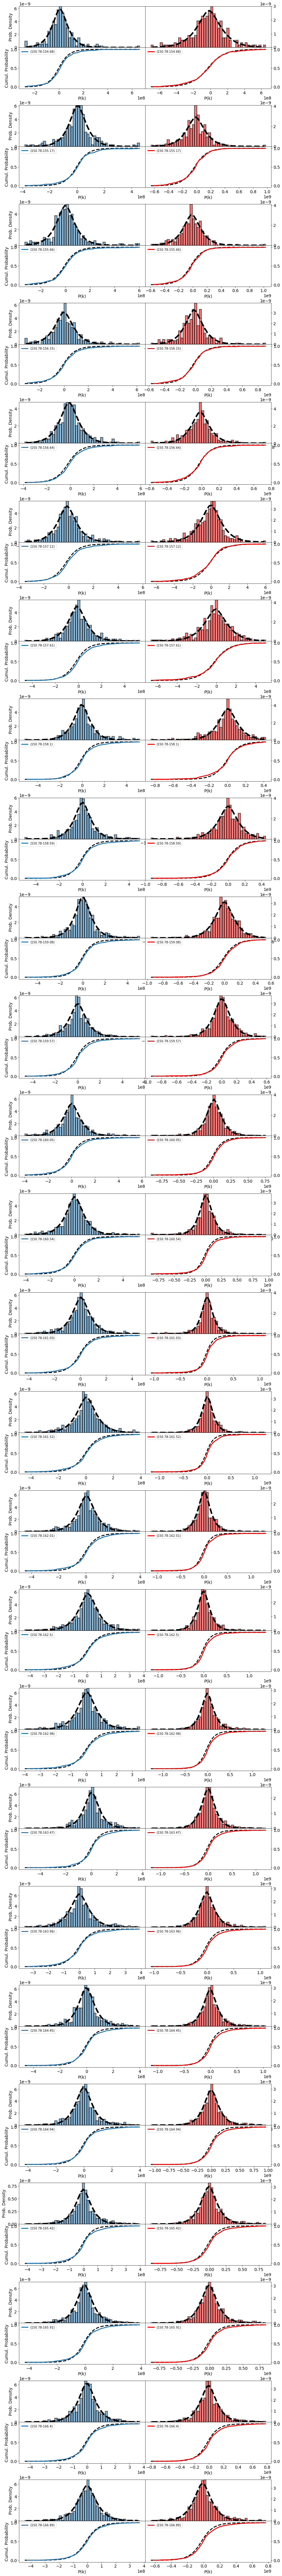

In [27]:
import matplotlib.gridspec as gridspec


plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

fig = plt.figure(constrained_layout=False)
import sys
#sys.stdout = open("KS-Tests-Results-extra-param-x0-direct-real", "w")

#We will store the histogram values to plot the cdf
cdf=[]
num_true=0
num_rows = len(spw_range)
#num_rows=26
gs = gridspec.GridSpec(num_rows,1)
gs.update(wspace=0.2, hspace=0.2)



data_array_pspec = []
data_array_direct = []
i=0
for pspec_pwr, direct_pwr, dly_ind_rng, spw_r in zip(null_pspec_power, null_direct_power,delay_index_range, spw_range):
    
    data_pspec = pspec_pwr.T[dly_ind_rng[0]:dly_ind_rng[1],:].flatten()
    data_direct = direct_pwr.T[dly_ind_rng[0]:dly_ind_rng[1],:].flatten()
    
    d,cv,result = ks_test(data_pspec,null_pdf,[0,np.std(data_pspec)])
    
    print(str(i)+" :The KS-test stats $D_n$ is %.3f." % (d))
    print("The critical value (significance level 0.05) is %.3f." % (cv))
    if result:
        print("The data follow the given distribution.")
        num_true = num_true +1
    else:
        print("The data do not follow the given distribution.")
    

    gss01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[i],wspace=0.0,hspace=0.0)
    ax0 = fig.add_subplot(gss01[0])
    ax1 = fig.add_subplot(gss01[2], sharex=ax0)
    ax2 = fig.add_subplot(gss01[1])
    ax3 = fig.add_subplot(gss01[3], sharex=ax2)

    p0 = ax0.hist(data_pspec,alpha=0.5,bins=50,density=True,linewidth=3,edgecolor='k',label="Pspec")
    ax2.yaxis.tick_right()
    ax3.yaxis.tick_right()
    p2 = ax2.hist(data_direct,alpha=0.5,bins=50,density=True,linewidth=3,edgecolor='k',label="Direct",color='r')
    
    # fit data to the model 
    cdf, popt, x = Fit_cdf_param(p0,[0,np.std(data_pspec.flatten())])
    

    ax1.plot(p0[1],cdf,lw=3,color='k',linestyle='--')
    ax0.plot(x,null_pdf(x, *popt),lw=5,color='k',linestyle='--')
    
    cdf, popt, x = Fit_cdf_param(p2,[0,np.std(data_direct.flatten())])
    ax3.plot(p2[1],cdf,lw=3,color='k',linestyle='--')
    ax2.plot(x,null_pdf(x, *popt),color='k',lw=5,linestyle='--')
    
    ax0.set_ylabel("Prob. Density",fontsize=14)
    ax1.set_ylabel("Cumul. Probability", fontsize=14)

    cdf_sum_pspec = np.cumsum(p0[0])/np.cumsum(p0[0])[-1] # calculate the cdf
    cdf_sum_direct = np.cumsum(p2[0])/np.cumsum(p2[0])[-1]
    
    
    ax1.plot(p0[1][1:],cdf_sum_pspec,alpha=1,label=spw_r,lw=3)
    ax3.plot(p2[1][1:],cdf_sum_direct,alpha=1,label=spw_r,color='r',lw=3)
    ax1.set_xlabel("P(k)",fontsize=14)
    ax3.set_xlabel("P(k)",fontsize=14)
    ax1.legend() 
    ax3.legend()
    
    i = i+1

fig.set_size_inches(w=15,h=6*num_rows)
#plt.savefig("null_power(even-odd)-22-on-26-accepted.pdf")
print("Follows distribution : "+str(num_true)+" on "+ str(len(spw_range)))
plt.show()